test qe

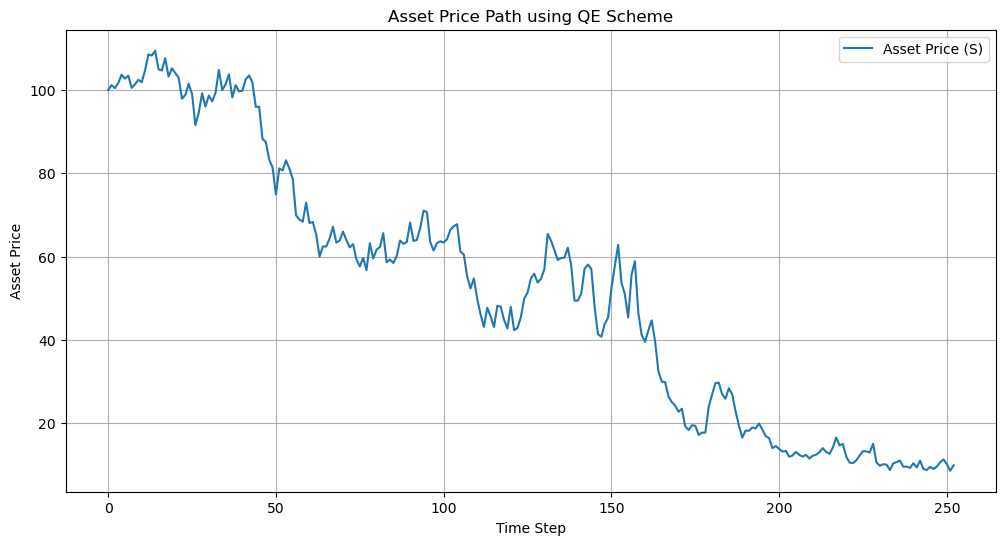

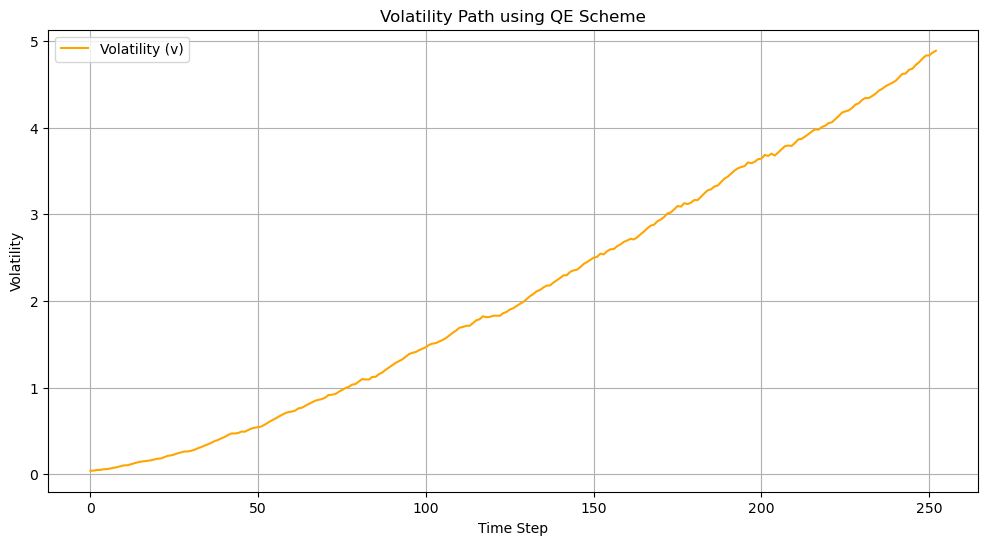

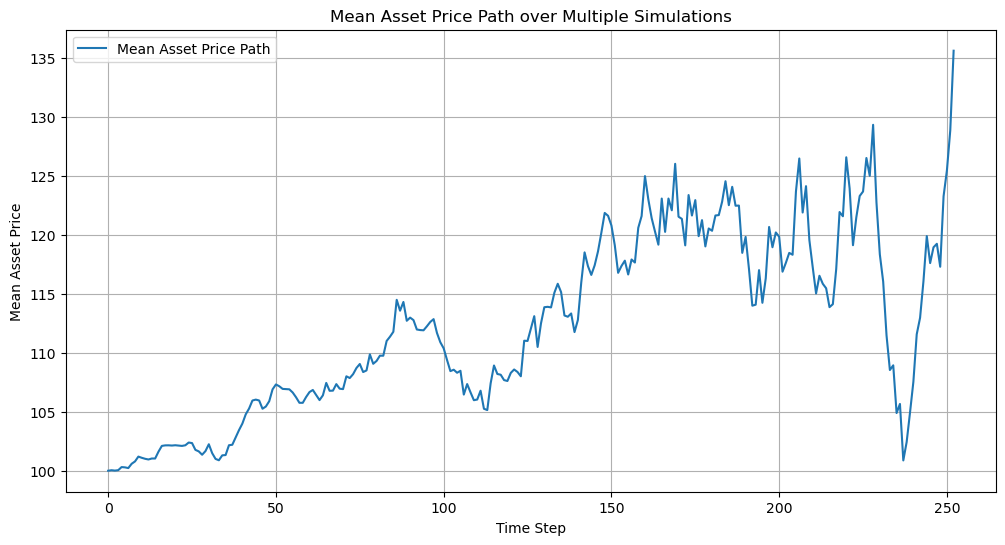

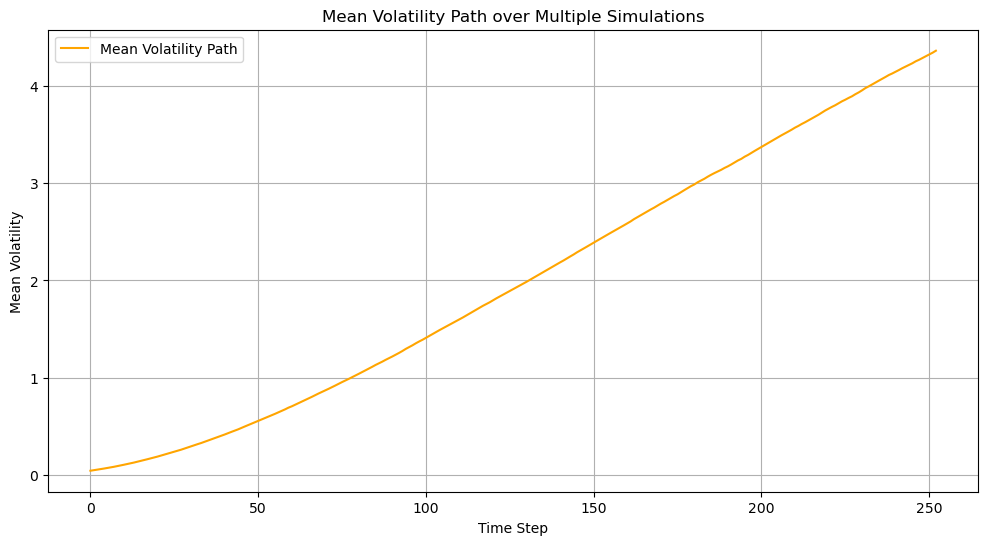

In [2]:
# Code Cell 1: Import necessary modules and define Heston model and QE Scheme

import numpy as np
import matplotlib.pyplot as plt
from HestonModel import HestonModel  # Ensure HestonModel is implemented
from QEScheme import QEScheme  # Ensure QEScheme class is defined

# Set Heston model parameters
S0 = 100        # Initial asset price
v0 = 0.04       # Initial volatility
kappa = 2.0     # Mean reversion rate
theta = 0.04    # Long-term mean
sigma = 0.3     # Volatility of volatility
rho = -0.7      # Correlation
r = 0.05        # Risk-free interest rate
T = 1           # Time to maturity
dt = 1/252      # Time step, assuming 252 trading days per year

# Create QE Scheme instance
qe_scheme = QEScheme(S0, v0, kappa, theta, sigma, rho, r)

# Code Cell 2: Generate paths for asset price and volatility

def generate_paths(scheme, S0, v0, T, dt):
    num_steps = int(T / dt)
    S_path = [S0]
    v_path = [v0]
    S, v = S0, v0
    
    for _ in range(num_steps):
        S, v = scheme.step(S, v, dt)
        S_path.append(S)
        v_path.append(v)
    
    return np.array(S_path), np.array(v_path)

# Generate paths
S_path, v_path = generate_paths(qe_scheme, S0, v0, T, dt)

# Code Cell 3: Visualize the asset price path

plt.figure(figsize=(12, 6))
plt.plot(S_path, label="Asset Price (S)")
plt.title("Asset Price Path using QE Scheme")
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.legend()
plt.grid(True)
plt.show()

# Code Cell 4: Visualize the volatility path

plt.figure(figsize=(12, 6))
plt.plot(v_path, label="Volatility (v)", color="orange")
plt.title("Volatility Path using QE Scheme")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

# Code Cell 5: Multiple simulations and result statistics

num_paths = 100  # Set the number of simulation paths
S_paths = []
v_paths = []

for _ in range(num_paths):
    S_path, v_path = generate_paths(qe_scheme, S0, v0, T, dt)
    S_paths.append(S_path)
    v_paths.append(v_path)

# Calculate the mean path of the asset price
mean_S_path = np.mean(S_paths, axis=0)
mean_v_path = np.mean(v_paths, axis=0)

# Code Cell 6: Visualize the mean paths

plt.figure(figsize=(12, 6))
plt.plot(mean_S_path, label="Mean Asset Price Path")
plt.title("Mean Asset Price Path over Multiple Simulations")
plt.xlabel("Time Step")
plt.ylabel("Mean Asset Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mean_v_path, label="Mean Volatility Path", color="orange")
plt.title("Mean Volatility Path over Multiple Simulations")
plt.xlabel("Time Step")
plt.ylabel("Mean Volatility")
plt.legend()
plt.grid(True)
plt.show()


semi-analytical pricer

In [8]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm

def heston_characteristic_function(u, T, S0, v0, r, kappa, theta, sigma, rho):
    """
    计算 Heston 模型的特征函数 phi(u).
    """
    i = complex(0, 1)
    
    # 计算 d 和 g，符合 Heston 特征函数的定义
    d = np.sqrt((rho * sigma * i * u - kappa)**2 + (u**2 + i * u) * sigma**2)
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    # 计算 C 和 D，特征函数中的两个核心项
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 
                                                      2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    D = ((kappa - rho * sigma * i * u - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
    
    # 返回复指数的特征函数值
    return np.exp(C + D * v0 + i * u * np.log(S0))

def heston_integrand(u, S0, K, T, r, v0, kappa, theta, sigma, rho, phi_num):
    """
    计算 Heston 模型下的积分部分，用于欧式看涨期权价格的计算。
    参数 phi_num 决定是否计算 phi1 或 phi2。
    """
    i = complex(0, 1)
    char_func_val = heston_characteristic_function(u - (i if phi_num == 1 else 0), T, S0, v0, r, kappa, theta, sigma, rho)
    numerator = np.exp(-i * u * np.log(K)) * char_func_val
    denominator = i * u
    return (numerator / denominator).real

def heston_call_price(S0, K, T, r, v0, kappa, theta, sigma, rho):
    """
    使用 Heston 半解析公式计算欧式看涨期权价格。
    """
    # 使用两个特征函数 phi1 和 phi2 分别计算期权价格
    integral_phi1, _ = quad(lambda u: heston_integrand(u, S0, K, T, r, v0, kappa, theta, sigma, rho, 1), 0, np.inf)
    integral_phi2, _ = quad(lambda u: heston_integrand(u, S0, K, T, r, v0, kappa, theta, sigma, rho, 2), 0, np.inf)
    
    # 使用两个积分结果计算看涨期权价格
    call_price = S0 * (0.5 + integral_phi1 / np.pi) - K * np.exp(-r * T) * (0.5 + integral_phi2 / np.pi)
    return call_price

# 设置 Heston 模型的参数
S0 = 100        # 初始资产价格
K = 100         # 期权执行价格
T = 1           # 到期时间
r = 0.05        # 无风险利率
v0 = 0.04       # 初始波动率
kappa = 2.0     # 均值回复速率
theta = 0.04    # 长期均值
sigma = 0.3     # 波动率的波动率
rho = -0.7      # 资产价格和波动率之间的相关性

# 计算欧式看涨期权价格（True Value）
true_price = heston_call_price(S0, K, T, r, v0, kappa, theta, sigma, rho)
print("Theoretical Call Option Price (Heston Model):", true_price)

Theoretical Call Option Price (Heston Model): 2008.2521168395315


BS

In [5]:
def black_scholes_call_price(S0, K, T, r, sigma):
    """
    使用 Black-Scholes 公式计算欧式看涨期权价格
    :param S0: 初始资产价格
    :param K: 期权执行价格
    :param T: 到期时间
    :param r: 无风险利率
    :param sigma: 恒定波动率
    :return: 看涨期权的理论价格
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# 设置 Black-Scholes 参数
S0 = 100       # 初始资产价格
K = 100        # 期权执行价格
T = 1          # 到期时间
r = 0.05       # 无风险利率
sigma = 0.2    # 恒定波动率（可以选择一个常量值作为对比）

# 计算 BS 模型下的看涨期权理论价格
true_price = black_scholes_call_price(S0, K, T, r, sigma)
print("Theoretical Call Option Price (Black-Scholes):", true_price)

Theoretical Call Option Price (Black-Scholes): 10.450583572185565
